### **ORIE 3120 Recitation 11**

## **1. Introduction**

**Due on Friday, May 7 at 11:59pm**

**Submit your solution as a ipynb**

In this recitation we will learn how to employ the newsvendor problem to solve a scheduling problem. More specifically, we want to find the optimal number of nurses to be scheduled to work on the quarantine & isolation team at Cornell Health to handle positive COVID tests.

Whenever a student tests positive, this team of nurses calls that student to check on their symptoms and to move them to a room at a hotel. The nursing team also calls students identified as close contacts of the positive student, and who may have already been infected, to move them into quarantine at a hotel. This is done to protect against the possibility that others would be infected by coming into contact with someone who is infectious. In many cases this is straightforward but it sometimes requires a substantial amount of work: the person being contacted might have a medical situation that requires extra attention (either from COVID or another condition); might not answer their phone (requiring repeated calls); might be belligerent or misrepresent the truth (requiring a longer conversation and sometimes the use of additional resources); or might simply have a great number of questions.

This is a newsvendor problem because demand is stochastic and there is a cost both for scheduling too few nurses, and for scheduling too many.  If we schedule too many nurses, we create a burden for them and risk burning out the nursing team. If we schedule too few, we can ask unscheduled nurses to come on and work at the last minute, but this forces them to drop their personal life and start working (creating a burden and risknig burnout). Also, scheduling too few nurses creates a risk that we might not be able to contact and move to quarantine / isolation all of the students who are potentially infectious, risking the creation of new COVID cases.

We focus on the arrival period for the Spring 2021 semester. During this period, students arriving from elsewhere were testing positive due to infections acquired at home. The rapid increase in arriving students and the changing nature of nationwide and international prevalence relative to the Fall 2020 semester made it difficult to plan based on past experience. This made mathematical modeling extremely useful. Indeed, code close to this recitation was actually used to make staffing decisions at Cornell Health over this period.

In [1]:
# Importing basic libraries
import numpy as np
import pandas as pd
import numpy.random as rand
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import math
import time
from IPython import display

# Setting the default parameters for the plots produced by matplotlib
# Sets figure size. Width, height in inches.
plt.rcParams["figure.figsize"] = (10,10)
# Sets label font sizes
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

## **2. Planning for a Single Day**

We will start by creating a model that plans for a single day, finding the optimal number of nurses to schedule for that day.

First, we will model the probability of testing positive for an arriving student by specifying some constants. 

We model students as arriving from one of the following location categories - 'New York State', 'Middle States', 'New England', 'Midwest', 'South', 'Southwest', 'West', 'Territories', 'USA, unknown', and 'International'. 

If we know the distribution of the arriving Cornell student population over these location categories, and the COVID prevalence at each of these locations, we can estimate the probability that an arriving student will person testing postive if they arrive from 'X' location.

We can get the data we need from
https://www.cornell.edu/about/facts.cfm

In [10]:
# Data from website
locations = ['New York State','Middle States','New England','Midwest','South',
            'Southwest','West','Territories','USA, unknown', 'International']    # Location categories
pop_percent = [27,12,7,6,8,3,11,2,2,22]  # Probability distribution of the origin locations for incoming Cornell students                                                                
covid_prevalence = [1.3,1.4,1.6,1.9,2.0,1.7,1.8,2.4,2.5,3.1]  # the probability that a person coming from each origin has COVID
# Both pop_percent and covid_percents are expressed as percentages between 0 and 100.

# Create a dataframe with the above information
data = pd.DataFrame(list(zip(locations, pop_percent, covid_prevalence)), columns=['location','pop_percent','covid_prevalence'])

data.head()

,location,pop_percent,covid_prevalence
0,New York State,27,1.3
1,Middle States,12,1.4
2,New England,7,1.6
3,Midwest,6,1.9
4,South,8,2.0


**Question 1:** Write code that calculates the probability that an arriving student tests positive. This is $$\sum_i P(\text{student origin is $i$}) P(\text{student is positive} | \text{origin is $i$})$$
Store this in a variable `prevalence` as a probability between 0 and 1.



In [13]:
prevalence = 0
for index, row in data.iterrows():
    prevalence += (row['pop_percent'] / 100) * (row['covid_prevalence']/100)

We will now run a simulation to generate many scenarios. 

Each scenario will include the number of positive students arriving on the day we are planning for, which is a binomial(p,n) random variable where p is the prevalence you calculated in question 1 and n is the number of students that arrive on that day. We set the number of arriving students to 1000.

It will then calculate the number of minutes of work required to handle those positive students, assuming that each positive case requires 30 minutes, each of their contacts requires 20 minutes, and each positive case has 4 contacts. 

It then calculates the number of nurses needed to do this work, assuming that each nurse works an 8 hour shift.

**Question 2:** Fill in the two missing lines in the code below

In [32]:
# Defining constants
num_arrivals = 1000 # Number of arriving students
M = 1000 # Number of simulation replications

nurses_needed = []
num_pos = [0]*M
work = [0]*M

# Run simulation
for m in range(M):
    num_pos[m] = np.random.binomial(num_arrivals, prevalence) # Simulate a binomial(N, prevalence) random variable    
    work[m] = num_pos[m] * 90 # 30 min per positive, 20 min per contact, 4 contacts, work defined in terms of minutes 
    nurses_needed.append(int(work[m] / (8*60))) # nurse works 8h (8 x 60 minutes) shift

simulation_df = pd.DataFrame(nurses_needed, columns = ['nurses_needed'])
simulation_df.head()

,nurses_needed
0,3
1,3
2,2
3,3
4,4


To optimize for the number of nurses we bring in, we will write a function that calculates the number of extra nurses required given that `N` nurses are currently working using our simulated data.

As discussed at the beginning of this recitation, there are two bad things that can happen: 
* the number of nurses scheduled on the day we are planning for could be *strictly more* than the number needed to do the work necessary on this day. In this case, the difference between the number scheduled and the number needed is called *overage*
* the number of nurses scheduled on the day we are planning for could be *strictly less* than the number needed to do the work necessary on this day. In this case, the difference between the number needed and the number scheduled is called *underage*.

In particular, if the number of nurses scheduled is N and the number of nurses needed is D, then:
* Overage = max(0,N-D)
* Underage = max(0,D-N)

We estimate the expected overage and expected underage associated with a particular number of scheduled nurses, we calculate the overage and underage on each scenario and return the average over all scenarios.

**Question 3:** Fill in the two lines below to define a function that calculates the overage and underage from `sim_df`.

Hint: One way to do this very quickly is to use the `clip` function with the `lower` keyword.  `df['x'].clip(lower=0)` returns the value of max(x,0) for each entry in `df['x']`.

In [33]:
def eval_N(nurses_needed, nurses_scheduled):
    overage = (nurses_scheduled - nurses_needed).clip(lower=0) # FILL IN
    underage = (nurses_needed - nurses_scheduled).clip(lower=0)# FILL IN
    return underage, overage

eval_N(simulation_df['nurses_needed'],1)

(0      2
 1      2
 2      1
 3      2
 4      3
 5      2
 6      2
 7      3
 8      2
 9      3
 10     2
 11     2
 12     1
 13     2
 14     1
 15     2
 16     2
 17     2
 18     3
 19     1
 20     5
 21     1
 22     4
 23     1
 24     3
 25     1
 26     2
 27     3
 28     1
 29     2
       ..
 970    3
 971    2
 972    3
 973    2
 974    1
 975    1
 976    3
 977    2
 978    2
 979    3
 980    2
 981    2
 982    2
 983    2
 984    1
 985    4
 986    3
 987    3
 988    2
 989    2
 990    3
 991    1
 992    2
 993    3
 994    3
 995    4
 996    1
 997    2
 998    1
 999    3
 Name: nurses_needed, Length: 1000, dtype: int64, 0      0
 1      0
 2      0
 3      0
 4      0
 5      0
 6      0
 7      0
 8      0
 9      0
 10     0
 11     0
 12     0
 13     0
 14     0
 15     0
 16     0
 17     0
 18     0
 19     0
 20     0
 21     0
 22     0
 23     0
 24     0
 25     0
 26     0
 27     0
 28     0
 29     0
       ..
 970    0
 971    0
 972    0
 

**Question 4**: Using `eval_N`, plot the underage and overage vs. the number of nurses scheduled. Do this for `nurses_scheduled` ranging from 0 to 9 inclusive. You should see that the underage is high when not many nurses are scheduled (our planned resourcing is *under* demand) and overage is high when many nurses are scheduled (our planned resourcing is *over* demand).

Text(0, 0.5, 'Overage')

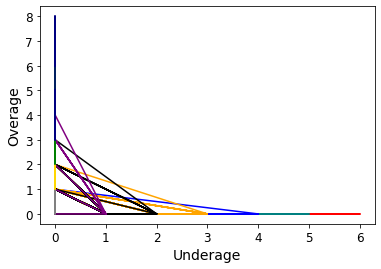

In [36]:
# Your code below
plt.plot(eval_N(simulation_df['nurses_needed'], 0)[0], eval_N(simulation_df['nurses_needed'], 0)[1], color = 'red')
plt.plot(eval_N(simulation_df['nurses_needed'], 1)[0], eval_N(simulation_df['nurses_needed'], 1)[1], color = 'teal')
plt.plot(eval_N(simulation_df['nurses_needed'], 2)[0], eval_N(simulation_df['nurses_needed'], 2)[1], color = 'blue')
plt.plot(eval_N(simulation_df['nurses_needed'], 3)[0], eval_N(simulation_df['nurses_needed'], 3)[1], color = 'orange')
plt.plot(eval_N(simulation_df['nurses_needed'], 4)[0], eval_N(simulation_df['nurses_needed'], 4)[1], color = 'black')
plt.plot(eval_N(simulation_df['nurses_needed'], 5)[0], eval_N(simulation_df['nurses_needed'], 5)[1], color = 'purple')
plt.plot(eval_N(simulation_df['nurses_needed'], 6)[0], eval_N(simulation_df['nurses_needed'], 6)[1], color = 'grey')
plt.plot(eval_N(simulation_df['nurses_needed'], 7)[0], eval_N(simulation_df['nurses_needed'], 7)[1], color = 'gold')
plt.plot(eval_N(simulation_df['nurses_needed'], 8)[0], eval_N(simulation_df['nurses_needed'], 8)[1], color = 'green')
plt.plot(eval_N(simulation_df['nurses_needed'], 9)[0], eval_N(simulation_df['nurses_needed'], 9)[1], color = 'navy')
plt.xlabel('Underage')
plt.ylabel('Overage')

Now, we want to define a function `optimize(df, alpha)`. It should return:
* the optimal number of nurses to schedule such that we minimize the total cost (alpha*underage + overage). 
* the underage and overage at this optimal number of nurses to schedule

We will assume that we can schedule N = 0 to 9 (inclusive) nurses. For each N find the cost and return the N with least associated cost. 

**Question 5**: A part of the function has been filled in for you. Please complete the function.

In [125]:
def optimize(nurses_needed, alpha):
    cost = [0]*10
    best_cost = np.inf
    opt_N = -1
    opt_underage = -1
    opt_overage = -1
    for N in range(10):
        # Your code here (fill in the for-loop)
        underage, overage = eval_N(nurses_needed, N)
        cost[N] = (alpha*underage + overage).mean()
        if N == 0: 
            opt_N = N
            opt_underage = underage.mean()
            opt_overage = overage.mean()
            best_cost = cost[N]
        if cost[N] < best_cost:
            opt_N = N
            opt_underage = underage.mean()
            opt_overage = overage.mean()
            best_cost = cost[N]
    return opt_N, opt_underage, opt_overage

**Question 6**: Test your function by using it to find the optimal N, underage and overage at these values:
* alpha = 0 (you should see that the optimal overage is 0 and the optimal N is 0)
* alpha = 1000 (you should see that the optimal underage is close to 0 and the optimal N is big)
* alpha = 1 (you should see the optimal underage and overage are similar to each other, and the optimal N is roughly in the middle between 0 and 10)

In [126]:
optimize(simulation_df['nurses_needed'],0)

(0, 3.127, 0.0)

In [127]:
optimize(simulation_df['nurses_needed'],1000)

(6, 0.0, 2.873)

In [128]:
optimize(simulation_df['nurses_needed'],1)

(3, 0.35, 0.223)

**Creating a Pareto Frontier**

Unfortunately, it isn't easy for a human decision-maker to tell you their objective function. Instead, what we can do is to plot things that must be traded off in an optimal solution and ask them to choose the trade-off they like the best. This is called a "Pareto Frontier".

We can do this here by solving the optimization problem for many different values of alpha, calculating the underage and overage for each one, and then plotting underage vs. overage.

The nurse manager or medical director would then be able to select a point on this curve that they think will be best.  We can then look up which value of alpha generated this point and what the optimal N was.

**Question 7:** 
Write code to create a Pareto frontier, 

Text(0, 0.5, 'Overage Nurses')

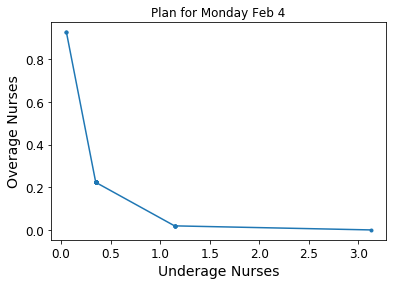

In [134]:
alpha = np.arange(0,2.5,.05)
overage = [0] * len(alpha)
underage = [0] * len(alpha)
opt_N = [0] * len(alpha)
for i in range(len(alpha)):
  # FILL IN YOUR CODE HERE
    overage[i] = optimize(simulation_df['nurses_needed'],alpha[i])[2]
    underage[i] = optimize(simulation_df['nurses_needed'],alpha[i])[1]
    opt_N[i] = optimize(simulation_df['nurses_needed'],alpha[i])[0]
plt.plot(underage,overage,'.-')
plt.title('Plan for Monday Feb 4')
plt.xlabel('Underage Nurses')
plt.ylabel('Overage Nurses')

When we show this plot to management, they say that they like the point that has underage closest to 0.4 (roughly speaking this means that the probability is 40% that we'll need to call in an extra nurse).

**Question 8:**  
What is the number of nurses that we should schedule to achieve this tradeoff between overage and underage? What is the value of alpha that gave us this optimal number of nurses?

In [141]:
for i in range(len(underage)):
    print(opt_N[i], underage[i],overage[i])

0 3.127 0.0
2 1.146 0.019
2 1.146 0.019
2 1.146 0.019
2 1.146 0.019
2 1.146 0.019
3 0.35 0.223
3 0.35 0.223
3 0.35 0.223
3 0.35 0.223
3 0.35 0.223
3 0.35 0.223
3 0.35 0.223
3 0.35 0.223
3 0.35 0.223
3 0.35 0.223
3 0.35 0.223
3 0.35 0.223
3 0.35 0.223
3 0.35 0.223
3 0.35 0.223
3 0.35 0.223
3 0.35 0.223
3 0.35 0.223
3 0.35 0.223
3 0.35 0.223
3 0.35 0.223
3 0.35 0.223
3 0.35 0.223
3 0.35 0.223
3 0.35 0.223
3 0.35 0.223
3 0.35 0.223
3 0.35 0.223
3 0.35 0.223
3 0.35 0.223
3 0.35 0.223
3 0.35 0.223
3 0.35 0.223
3 0.35 0.223
3 0.35 0.223
3 0.35 0.223
3 0.35 0.223
3 0.35 0.223
3 0.35 0.223
3 0.35 0.223
3 0.35 0.223
3 0.35 0.223
4 0.054 0.927
4 0.054 0.927


The optimal number of nurses to schedule is 3. The values of alpha 0.35 - 2.4 will give us this optial number of nurses.

## **3. Planning for Multiple Days**

### Setup

Our current model only simulates a single day. However, we would like to have an optimal schedule for the number of nurses to employ for an entire period, say 3 weeks. We could do this by making 21 plots using the code above, one for each day, using the number of students scheduled to arrive for that day. We could then show each of those 21 plots to management and have them pick out a point on each plot. This would be a pain, however. It is better to show them a single plot for the entire 3-week period and have them select a point.

In addition, we would like to introduce the possibility that a student does not test positive immediately upon arriving and thus contacts multiple students during the time he/she goes undetected. For simplicity, we do not assume the contacted students spread the virus to other contacts.

For example, a student arriving on day 0 may not test positive until day 4, and he/she may contact 6 students. We will implement this improved model below. 

Before we do so, note that our objective is essentially still the same as above: for a particular $\alpha$ optimally choose the number of nurses to schedule to minimize the expected total cost. However, our choice of nurses to schedule is no longer a scalar, since we are considering *many* days as opposed to a single day. Rather, it is a vector (say, $\vec{N}$) whose length is the number of days in the period we are considering, and whose $j$th entry is our choice of the number of nurses to employ on day $j$.  

---
*For the mathematically inclined, our problem can be restated as the following optimization problem. (You may skip reading this cell, but it may help give you a better understanding of the problem at hand.)*

Let $(N_1, ..., N_D) = \vec{N}$ be a vector giving the number of nurses that will work on each day ($1$ through $D$), then, for a particular value of $\alpha$, our objective function is:

Objective$(\vec{N})$ = ExpectedTotalOverage($\vec{N}$) + $\alpha \cdot$ ExpectedTotalUnderage($\vec{N}$) 

= $\sum_{d=1}^{D}$ $E$ (Overage for day $d$ + $\alpha \cdot$ Underage for day $d$ | We use $N_d$ nurses on day $d$) 

$\approx$ $\sum_{d=1}^{D}$ $\frac{1}{M}$ $\sum_{i=1}^{M}$ (Overage for day $d$ $+ \alpha \cdot$ Underage for day $d$ | We use $N_d$ nurses on day $d$ and the random outcome for simulation $i$ is $(amount\_of\_work)_i \in \mathbb{R}_{\geq 0}$) where $M$ is the number of simulations.

Let $N^*(\alpha)$ be the optimal choice of $N_1,...,N_D$ for a particular $\alpha$ (i.e. the $\vec{N}$ that minimizes the Objective function), then we would like to ultimately plot the _Pareto Frontier_ : ExpectedTotalOverage($N^*(\alpha)$) vs. ExpectedTotalUnderage($N^*(\alpha)$).

---

# Simulation

Here we'll simulate scenarios, where each scenarios consists of the amount of work that needs to be done on each day during the first 3 weeks of the semester

In [142]:
num_days = 21
num_scenarios = 20

# This is the number of people who arrive on each day.
# It was generated using num_arrivals = np.ceil(2000*rand.uniform(size=num_days)) 
num_arrivals = [1076., 1752., 1783., 1326., 1385., 1454., 1230.,  689., 1190.,
       1853., 1716.,  405.,   70., 1097., 1504.,  634., 1407., 1222.,
       1140.,  404., 1703.]

In [147]:
# Create a dataframe containing all 0's where each row will be a scenario
# and each column will be a simulated day.  Once we run the code below, the
# values in the dataframe will be the number of nurses needed on each day in 
# each scenario
df_sim = pd.DataFrame(0, index=range(num_scenarios), columns=range(num_days))

for i in range(num_scenarios):
  for d in range(num_days): # Iterate over days in our simulation
    # Simulate the students who arrive on this day
    infected_no = rand.binomial(num_arrivals[d],prevalence)
    for j in range(infected_no):
      days_infectious = rand.geometric(0.3)
      day_tested_positive = d + days_infectious
      if day_tested_positive < num_days:
        contacts = 1.5*days_infectious
        df_sim.loc[i,day_tested_positive] += (30 + 20 * contacts)/(8*60)

In [149]:
df_sim.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0,1.125,2.2500,3.7500,3.1875,3.4375,5.8125,6.9375,6.3750,2.9375,...,7.750,6.2500,5.3125,6.0625,4.7500,3.0000,5.1875,7.8750,6.2500,4.7500
1,0,0.500,1.3750,2.7500,3.9375,3.0625,4.7500,4.0000,4.9375,5.5000,...,7.875,5.2500,4.1875,7.1875,7.1875,3.0625,6.8125,5.9375,8.7500,6.1250
2,0,0.875,1.6250,3.9375,4.0000,6.0625,8.5625,4.6250,7.1250,6.5625,...,7.000,6.3125,5.3125,6.5000,4.1250,4.4375,3.8750,4.2500,4.6250,4.0625
3,0,1.125,1.5625,4.5625,4.4375,5.8750,5.1250,5.8750,5.3750,6.2500,...,4.875,5.8750,9.2500,5.8125,9.6875,5.8125,9.8750,5.3125,6.5000,5.0000
4,0,1.125,2.8125,5.0625,4.6250,4.5625,6.0625,5.8750,4.8750,5.6875,...,7.000,6.7500,7.1250,4.1875,3.8125,4.9375,3.8125,4.6875,6.8125,4.2500


**Question 9**: Change the above code so that the number of contacts depends on the number of days the person is infectious. Let the number of contacts be 1.5 times the number of days infectious. This models the fact that a person who has been circulating in the campus population is going to have more local contacts.

**Question 10:** Plot the average amount of work per day vs. day, averaging across all of the scenarios.  You will probably see that the amount of work is larger for later days, even though the distribution over the number of arriving students and the prevalence was the same on every day.  Why is that?

Text(0, 0.5, 'Average work per day')

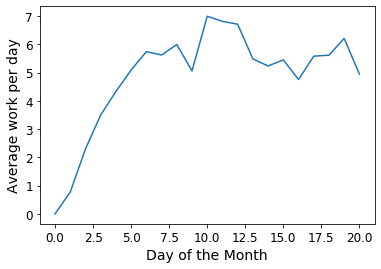

In [153]:
day = np.arange(0,21,1)
plt.plot(day, df_sim[day].mean())
plt.xlabel("Day of the Month")
plt.ylabel("Average work per day")

This could be because as the days go on, the probability of finding additional positive students who might be contacts of the initial positive tests will increase, and even more basic, the amount of work to track down and test the contacts will increase as well.

# Optimization

For each value of alpha, we will now find the optimal schedule of nurses. This is just like we did above, except now we will take multiple days into account. Fortunately, the optimal schedule over multiple days for a given alpha can be optimized separately for each day.

To optimize for a given value of alpha, we need to use the `optimize` function we wrote above. We use this to figure out the optimal number of nurses to schedule on that day, treating that day separately from all other days. This also tells us the optimal underage and overage on that day.

We can then add up the overage and underage costs across all days to get the total underage and overage.

**Question 11** Fill in the missing line of code below using your `optimize` function to complete this.

In [154]:
best = pd.DataFrame()
best['alpha'] = np.arange(0,5,.25)
best['underage'] = 0
best['overage'] = 0

In [156]:
for index, row in best.iterrows():
  for d in df_sim.columns:
    opt_N, underage, overage = optimize(df_sim[d],best.loc[index,'alpha'])
    # These are the total values, across all days
    best.loc[index,'underage'] += underage
    best.loc[index,'overage'] += overage

In [157]:
best

,alpha,underage,overage
0,0.00,102.209375,0.000000
1,0.25,23.440625,2.231250
2,0.50,14.662500,5.453125
3,0.75,12.184375,6.975000
4,1.00,10.568750,8.359375
5,1.25,8.221875,11.012500
6,1.50,7.806250,11.596875
7,1.75,5.518750,15.309375
8,2.00,5.518750,15.309375
9,2.25,5.200000,15.990625


Text(0, 0.5, 'Overage')

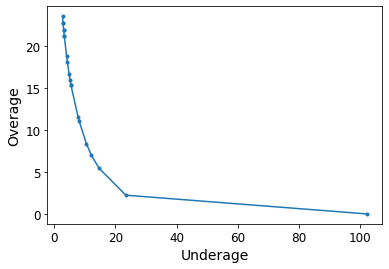

In [158]:
plt.plot(best['underage'],best['overage'],'.-')
plt.xlabel('Underage')
plt.ylabel('Overage')

**Question 12**
Suppose that leadership says that they prefer the solution whose total underage over the 21 day period is closest to 10. What value (or values) of alpha that you searched does this correspond to?  How many nurses are scheduled on each day under the optimal schedule for this choice for alpha? (If multiple values of alpha produce underage costs that are closes to 10, pick one.)

In [160]:
best.loc[4,'alpha']

1.0

This corresponds to an alpha of about 1, which from the above analysis we know corresponds to 3 nurses. 